## **Predicting Loan Default Risk Using Financial Data**

### **Import Librairies**

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### **Import data**

In [2]:
loan_pred_df = pd.read_csv("C:/Users/niibo/Desktop/Loan Prediction ML/loan_default_risk_data.csv")
loan_pred_df.head()

,age,income,loan_amount,credit_score,employment_status,marital_status,education_level,loan_term,loan_purpose,default
0,56,22695,44353,697,Unemployed,Divorced,Master,12,Car,1
1,46,68190,22675,576,Employed,Single,Bachelor,24,Car,0
2,32,25258,49417,803,Employed,Divorced,Master,12,Education,0
3,60,107538,28938,691,Employed,Single,PhD,12,Home,0
4,25,59504,28664,434,Unemployed,Single,High School,12,Home,1


### **Metadata of data**

In [3]:
print("No of columns: ", loan_pred_df.shape[1])
print("No of rows: ", loan_pred_df.shape[0])

No of columns:  10
No of rows:  100


### **Data Preprocessing**

In [4]:
# Check for missing values
missing_values = loan_pred_df.isnull().sum()
print("missing Values: ")
missing_values

missing Values: 


age                  0
income               0
loan_amount          0
credit_score         0
employment_status    0
marital_status       0
education_level      0
loan_term            0
loan_purpose         0
default              0
dtype: int64

In [5]:
# Check the assigned datatype
loan_pred_df.dtypes

age                   int64
income                int64
loan_amount           int64
credit_score          int64
employment_status    object
marital_status       object
education_level      object
loan_term             int64
loan_purpose         object
default               int64
dtype: object

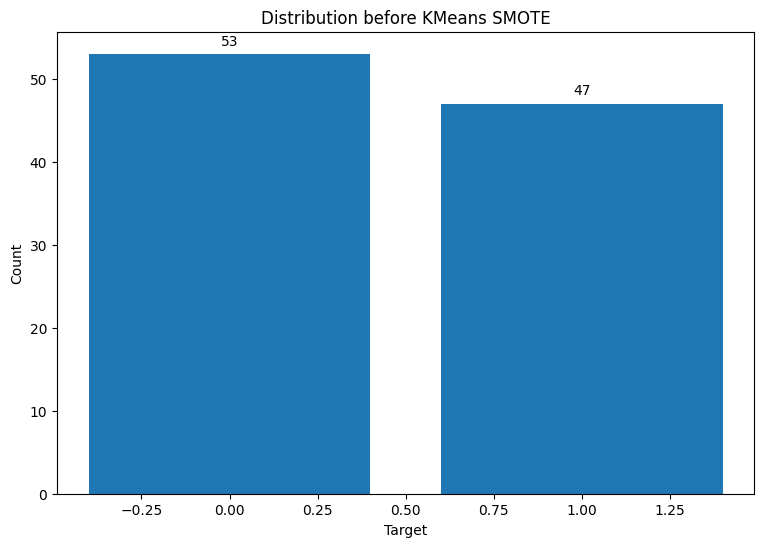

In [6]:
# Address the default class by using any under or over sampling technique
# Use of the Kmeans SMOTE Oversampling technique

x = loan_pred_df.drop('default', axis = 1)
y = loan_pred_df['default']
target = loan_pred_df['default'].value_counts()

plt.figure(figsize = (9, 6))
plt.bar(target.index, target.values)
plt.title('Distribution before KMeans SMOTE')
plt.ylabel('Count')
plt.xlabel('Target')
for i, v in enumerate(target.values):
    plt.text(i, v + 0.02*max(target.values), str(v), ha = 'center')
plt.show()

In [7]:
# must one-hot encode the categorical columns before applying KMeans SMOTE
encoder = OneHotEncoder()
x_encoded = encoder.fit_transform(x)
kmeans_smote = KMeansSMOTE(
    random_state=42,           
    sampling_strategy='auto',k_neighbors=5,    
    cluster_balance_threshold='auto')
x_resampled, y_resampled = kmeans_smote.fit_resample(x_encoded, y)

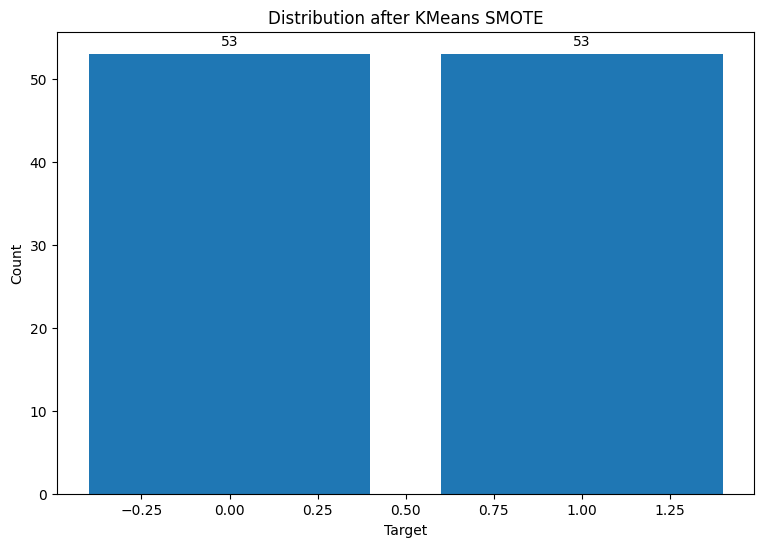

In [8]:
# Visualize the balanced dataset
plt.figure(figsize = (9, 6))
plt.bar(target.index, pd.Series(y_resampled).value_counts())
plt.title('Distribution after KMeans SMOTE')
plt.ylabel('Count')
plt.xlabel('Target')
for i, v in enumerate(pd.Series(y_resampled.value_counts())):
    plt.text(i, v + 0.02*max(pd.Series(y_resampled.value_counts())), str(v), ha = 'center')
plt.show()

## **Feature Engineering and Selection**

In [9]:
# Analyze the features to identify the most significant ones for loan default prediction
X = loan_pred_df[['income', 'loan_amount', 'credit_score', 'employment_status', 'loan_purpose', 'loan_term','education_level',
                  'age', 'marital_status']]
Y = loan_pred_df[['income', 'loan_amount', 'credit_score', 'employment_status', 'loan_purpose', 'loan_term']]

In [10]:
# Encode categorical variables using techniques like one-hot encoding or label encoder
categorical_cols = ['employment_status', 'marital_status', 'education_level', 'loan_purpose']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    loan_pred_df[col] = le.fit_transform(loan_pred_df[col])
    le_dict[col] = le

In [11]:
loan_pred_df

,age,income,loan_amount,credit_score,employment_status,marital_status,education_level,loan_term,loan_purpose,default
0,56,22695,44353,697,1,0,2,12,0,1
1,46,68190,22675,576,0,2,0,24,0,0
2,32,25258,49417,803,0,0,2,12,1,0
3,60,107538,28938,691,0,2,3,12,2,0
4,25,59504,28664,434,1,2,1,12,2,1
...,...,...,...,...,...,...,...,...,...,...
95,24,113557,26357,419,1,2,1,24,3,0
96,26,81087,16969,357,0,0,3,48,0,1
97,41,115839,7869,645,0,0,2,12,2,1
98,18,88840,33643,773,0,2,2,48,0,0


In [12]:
#  standardize numerical features like income, loan amount, and credit score for better model performance. 
scaler = StandardScaler()
scaled = scaler.fit_transform(loan_pred_df[['income', 'loan_amount', 'credit_score']])


## **Exploratory Data Analysis (EDA)**

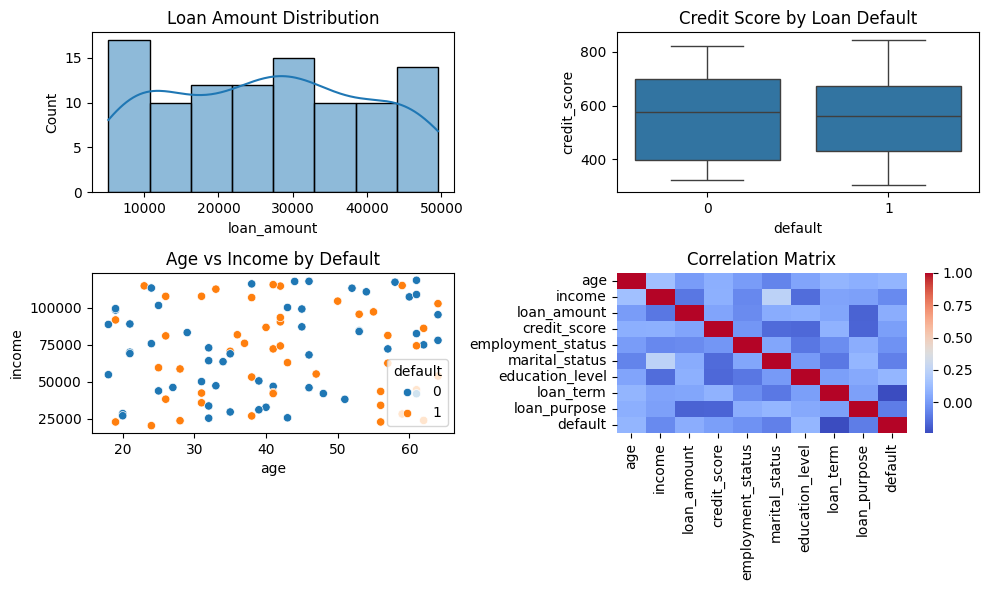

In [13]:
# Visualize the data using histograms, box plots, and scatter plots to identify patterns and relationships between features.
# scatter plot between loan term and credit score

plt.figure(figsize = (10, 6))

# Histogram of loan amounts
plt.subplot(2, 2, 1)
sns.histplot(loan_pred_df['loan_amount'], kde=True)
plt.title('Loan Amount Distribution')

# Boxplot of credit score
plt.subplot(2, 2, 2)
sns.boxplot(x='default', y='credit_score', data=loan_pred_df)
plt.title('Credit Score by Loan Default')

# Scatter plot for age vs income
plt.subplot(2, 2, 3)
sns.scatterplot(x='age', y='income', hue='default', data=loan_pred_df)
plt.title('Age vs Income by Default')

# Correlation heatmap
plt.subplot(2, 2, 4)
sns.heatmap(loan_pred_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

## **Model Training and Evaluation**

In [14]:
loan_pred_df.head()

,age,income,loan_amount,credit_score,employment_status,marital_status,education_level,loan_term,loan_purpose,default
0,56,22695,44353,697,1,0,2,12,0,1
1,46,68190,22675,576,0,2,0,24,0,0
2,32,25258,49417,803,0,0,2,12,1,0
3,60,107538,28938,691,0,2,3,12,2,0
4,25,59504,28664,434,1,2,1,12,2,1


In [15]:
# Split the data into training and testing sets 
X_test, X_train, y_test, y_train = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [19]:
import pandas as pd

# 1. Convert all categorical text columns into numbers
loan_pred_df = pd.get_dummies(loan_pred_df, drop_first=True)

# 2. Re-define your features and target (adjust names to match your data)
X = loan_pred_df.drop('default', axis=1) 
y = loan_pred_df['default']
# 3. Now perform your train_test_split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 4. NOW your model will work
model = RandomForestClassifier()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:

y_pred = model.predict(X_test)

 # Evaluation for each model
print(f"Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

Random Forest Model Evaluation:
Accuracy: 0.7
Precision: 1.0
Recall: 0.45454545454545453
F1 Score: 0.625
ROC-AUC: 0.7272727272727273


In [22]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# ────────────────────────────────────────────────
# correct identification (safer than select_dtypes in some cases)
# ────────────────────────────────────────────────
known_numeric = ['age', 'income', 'loan_amount', 'credit_score', 'loan_term']
known_categorical = ['employment_status', 'marital_status', 'education_level', 'loan_purpose']

# Verify they exist
missing_num  = [c for c in known_numeric    if c not in X_train.columns]
missing_cat  = [c for c in known_categorical if c not in X_train.columns]

if missing_num or missing_cat:
    print("Missing columns!", missing_num, missing_cat)
else:
    print("All expected columns found ✓")

# ────────────────────────────────────────────────
# Numeric pipeline – only on real numbers
# ────────────────────────────────────────────────
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # median is fine for numbers
    ('scaler',  StandardScaler())
])

# ────────────────────────────────────────────────
# Categorical pipeline – handles strings
# ────────────────────────────────────────────────
categorical_transformer = Pipeline(steps=[
    ('imputer',   SimpleImputer(strategy='most_frequent')),  # most common category
    ('encoder',   OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ────────────────────────────────────────────────
# Combine – now impossible to mix numeric strategy on strings
# ────────────────────────────────────────────────
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, known_numeric),
        ('cat', categorical_transformer, known_categorical)
    ],
    remainder='drop'   # ignore any other columns
)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',   RandomForestClassifier(random_state=42))
])

# Train
pipeline.fit(X_train, y_train)
print("Training finished without median/string error")

All expected columns found ✓
Training finished without median/string error


In [ ]:
# Save the model
joblib.dump(pipeline, 'rf_model.pkl')

['rf_model.pkl']